# Technical note: Sensitivities of a logistic model

In this note we look at a logistic model, defined with initial conditions that depend on model parameters.

## The model

Parameters:
\begin{align}
K &= ???\\
h &= 0.75
\end{align}

State:
\begin{align}
\frac{dy}{dt} = h y (1 - y)
\end{align}

Initial condition:
\begin{align}
y(t_0, K, h) = \left[1 + \exp(-h(t_0 + K \log 10)) \right]^{-1}
\end{align}

Remembering that Myokit defines $t_0 \equiv 0$ we get

Initial condition:
\begin{align}
y(t_0, K, h) = \left[1 + \exp(-h K \log 10) \right]^{-1}
\end{align}

### In Myokit 1.34 and newer

Using the syntax defined from Myokit 1.34.0 onwards, we can write:

In [33]:
import myokit

model = myokit.parse_model(
'''
[[model]]
c.y = 1 / (1 + exp(-c.h * c.K * log(10)))

[engine]
time = 0 bind time

[c]
h = 0.75
K = -2.25
dot(y) = h * y * (1 - y)
''')

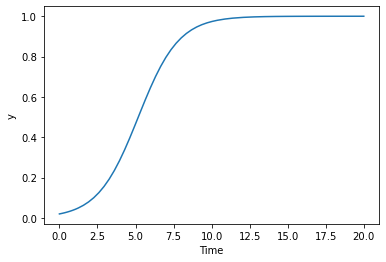

In [37]:
s = myokit.Simulation(model)
d = s.run(20)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('Time')
ax.set_ylabel('y')
ax.plot(d.time(), d['c.y'])
plt.show()

### Proposed API

At the moment, we can't do this:

In [38]:
s = myokit.Simulation(model, sensitivities=(['c.y'], ['c.h', 'c.K']))

NotImplementedError: Sensitivities with respect to parameters used in initial conditions is not implemented (1 / (1 + exp(-c.h * c.K * log(10))) depends on c.h).

The reason for this error is that the simulation stores its _state_ and _default state_ as lists of floating point numbers, so no room for fancy expressions!

## Requirements

- The new API should be backwards compatible wherever possible. Users who do not use the new functionality should not have to change their scripts.
- The existing system with a `state`, `default_state` and `reset()`+`pre()` is already slightly confusing to new users. The new system should not be significantly more confusing.

Specific methods:
- The methods `sim.state()` and `sim.set_state()` should probably stay working with floats?
- The methods `default_state` and `set_default_state` are less frequently used, and so can maybe be changed a bit?
- The method `reset()` currently resets `state` to the `default_state`, this should be maintained
- The method `pre()` runs a simulation and sets `default_state` to the resulting (numerical) state. This should be maintained
- The method `set_constant()` can be used to change a constant. Should this impact initial states?

Implementation:

I FORGOT. SOMETHING WITH UDATA AND POINTERS



## Proposal 1: The default state can use expressions

This mechanism was proposed by Martin in https://github.com/myokit/myokit/pull/899.

In short:
- `sim.state()` and `set_state()` use floats.
- `sim.default_state()` and `set_default_state` use expressions.
- When a simulation is created, `state` is set to the evaluation of `default_state`
- `pre()` sets the default state to Number objects, so variable references are lost
- `reset()` sets `state` to the evaluation of `default_state`
- Using `set_constant` affects `default_state`, but not `state` (which is floats!). So if the effect of a `set_constant` call should be propagated to the state, `reset()` should be called.

### Examples

### Implementation